In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import LabelEncoder

In [18]:
train_df = pd.read_csv('../Data/combined_train.csv')

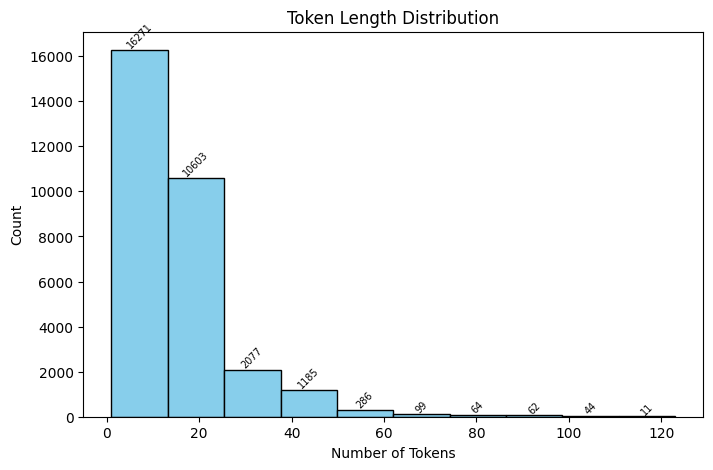

In [ ]:
# Token length:
train_df['token_length'] = train_df['text_cleaned'].astype(str).apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(8, 5))
counts, bins, patches = ax.hist(train_df['token_length'], color='skyblue', edgecolor='black')
ax.set_title('Token Length Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Count')

# Add value counts for the bins
for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=7, rotation=45)

plt.show()

## Variable Distributions

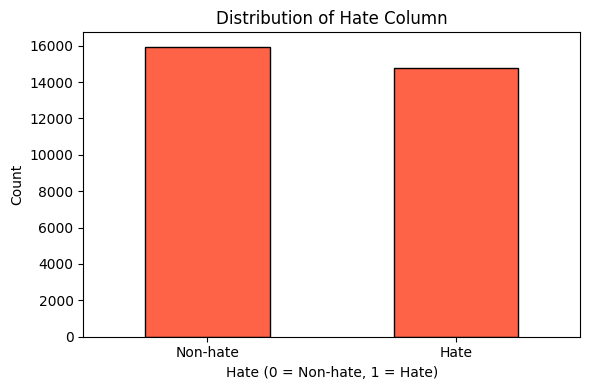

In [20]:
plt.figure(figsize=(6, 4))
train_df['hatespeech'].value_counts().sort_index().plot(
    kind='bar', color='tomato', edgecolor='black'
)
plt.title('Distribution of Hate Column')
plt.xlabel('Hate (0 = Non-hate, 1 = Hate)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-hate', 'Hate'], rotation=0)
plt.tight_layout()
plt.show()

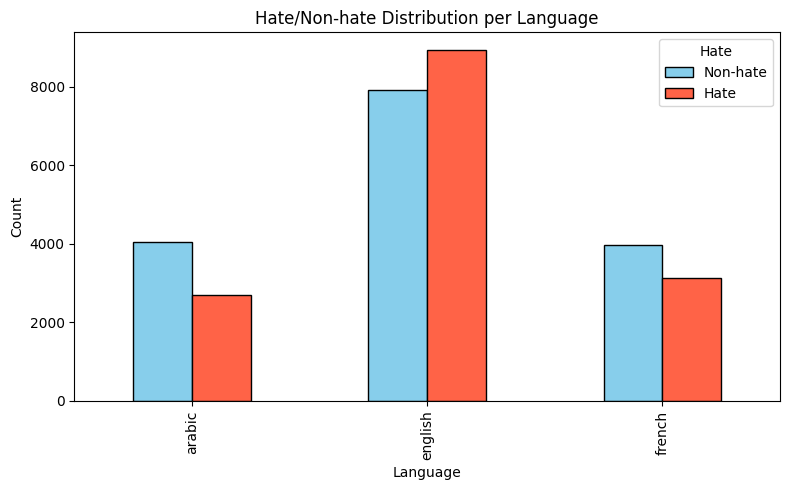

In [21]:
# Crosstab for hate/non-hate per language
hate_lang_ct = pd.crosstab(train_df['language'], train_df['hatespeech'])

# Plot
hate_lang_ct.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'tomato'], edgecolor='black')
plt.title('Hate/Non-hate Distribution per Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(['Non-hate', 'Hate'], title='Hate')
plt.tight_layout()
plt.show()

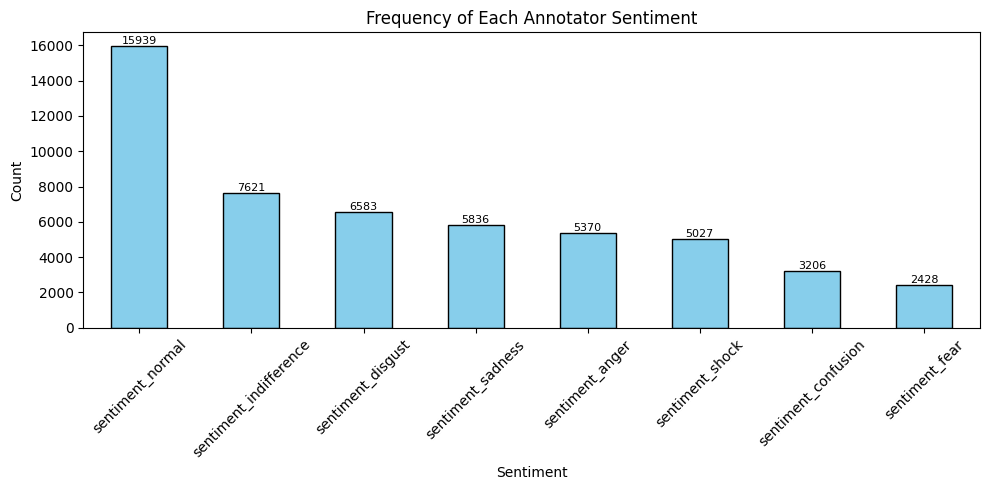

In [22]:
# List of sentiment columns
sentiment_cols = ['sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Sum each sentiment column to get counts
sentiment_counts = train_df[sentiment_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
ax = sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Annotator Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value counts on top of bars
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(int(count)), ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

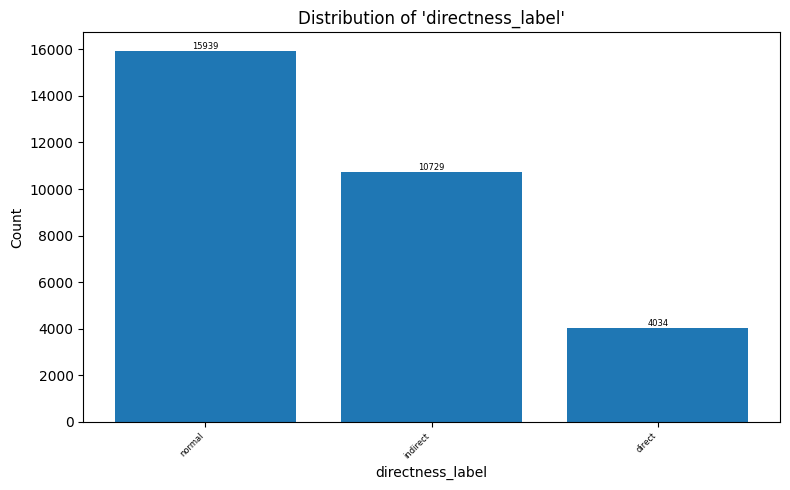

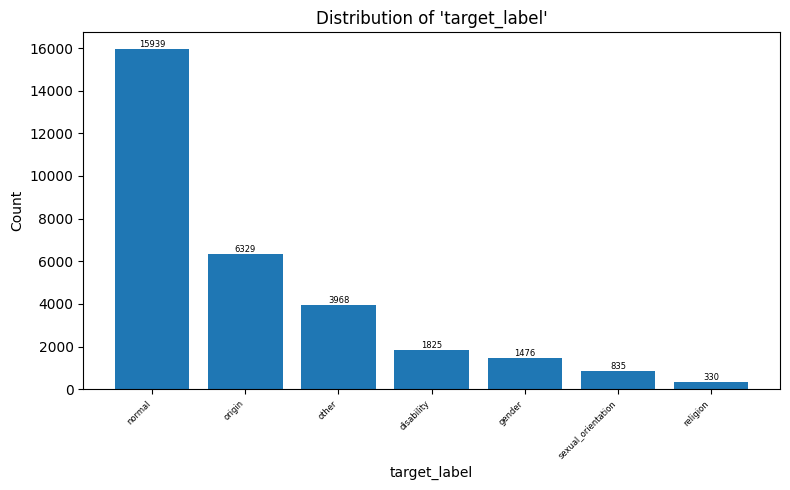

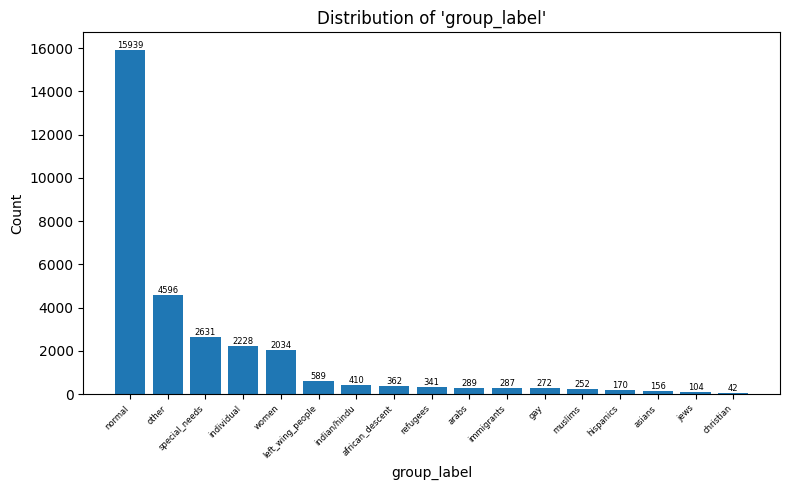

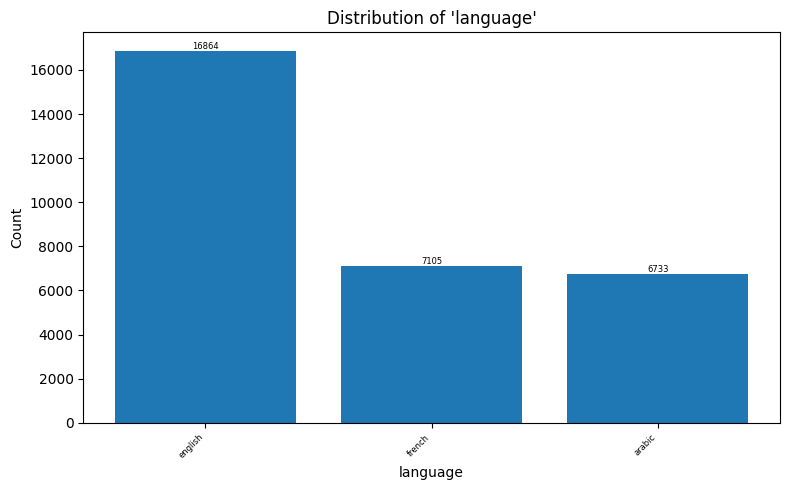

In [23]:
with open('../Data/label_maps.json', 'r') as f:
    label_maps = json.load(f)

def plot_distribution(column, label_map=None):
    value_counts = train_df[column].value_counts().sort_values(ascending=False)
    labels = value_counts.index.astype(str)
    if label_map:
        # Convert index to original labels if mapping provided
        labels = [label_map[str(idx)] if str(idx) in label_map else str(idx) for idx in value_counts.index]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, value_counts.values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f"Distribution of '{column}'")
    plt.xticks(rotation=45, ha='right', fontsize=6)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
                 ha='center', va='bottom', fontsize=6)
    plt.tight_layout()
    plt.show()

plot_distribution('directness_label', label_maps['directness'])
plot_distribution('target_label', label_maps['target'])
plot_distribution('group_label', label_maps['group'])
plot_distribution('language')  # No mapping needed if already string

## Correlation and Co-occurrences

                        language_label  directness_label  target_label  \
language_label                1.000000         -0.077271      0.021387   
directness_label             -0.077271          1.000000     -0.390211   
target_label                  0.021387         -0.390211      1.000000   
group_label                  -0.162691          0.152705     -0.315702   
sentiment_indifference        0.003556         -0.511531      0.253278   
sentiment_disgust            -0.030593         -0.418063      0.131975   
sentiment_sadness             0.093529         -0.425713      0.127301   
sentiment_anger               0.009444         -0.365907      0.125978   
sentiment_shock               0.016141         -0.414853      0.166057   
sentiment_normal             -0.025845          0.899496     -0.392559   
sentiment_confusion           0.035726         -0.263870      0.086909   
sentiment_fear                0.043797         -0.245994      0.064424   

                        group_label  

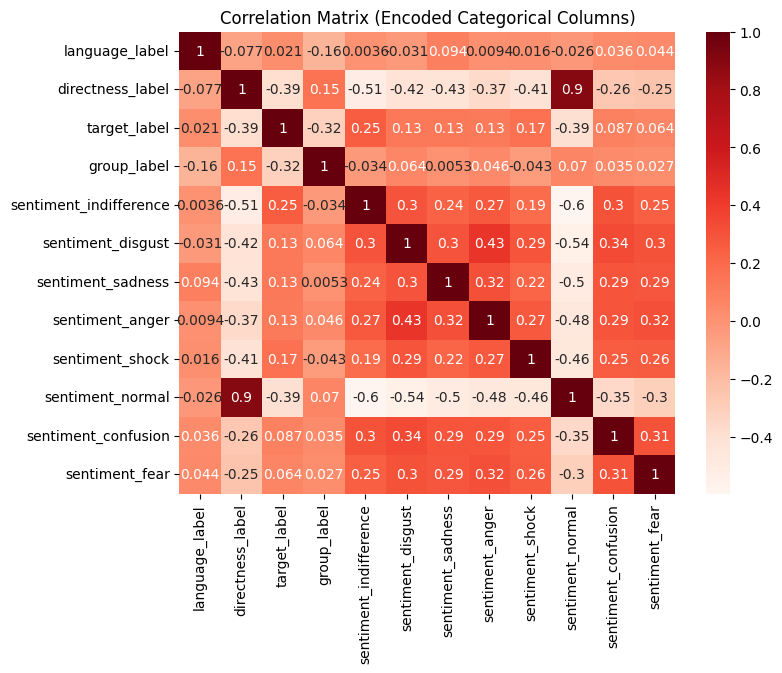

In [24]:
le = LabelEncoder()
train_df['language_label'] = le.fit_transform(train_df['language'].astype(str))

# Label encode the 5 categorical columns
categorical_cols = ['language_label', 'directness_label', 'target_label', 'group_label',
                    'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger',
                    'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear']

# Create a DataFrame with only the encoded columns
encoded_df = train_df[[col for col in categorical_cols]]

# Show correlation matrix for the encoded categorical columns
correlation_matrix = encoded_df.corr()
print(correlation_matrix)

# Optional: visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.title('Correlation Matrix (Encoded Categorical Columns)')
plt.show()


Language Cooccurrences


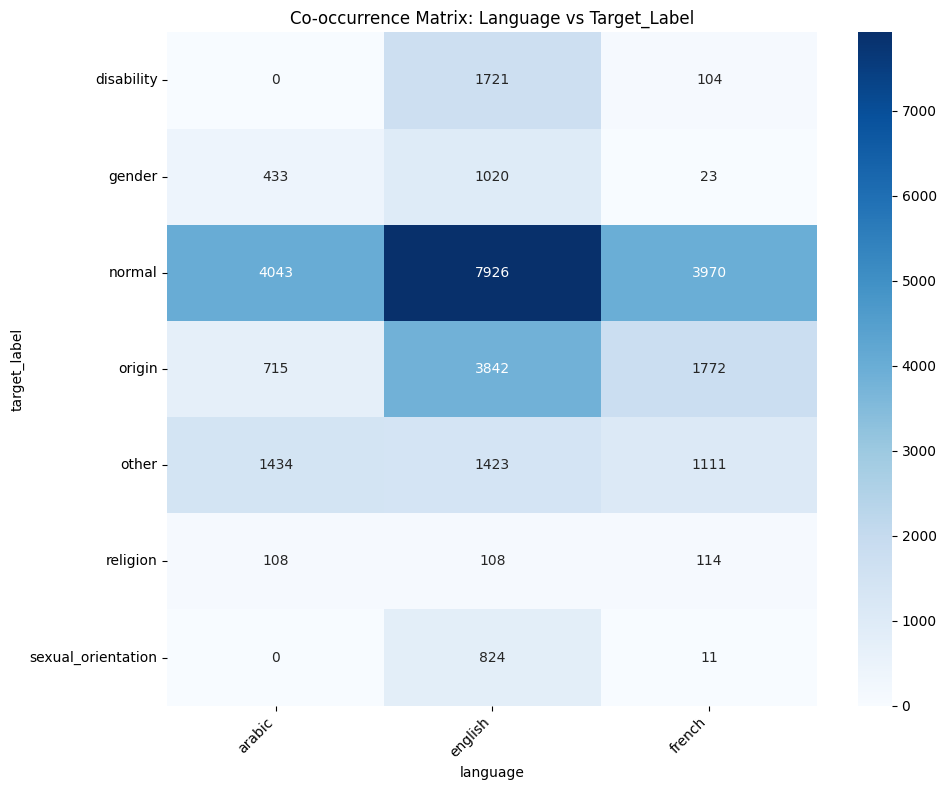

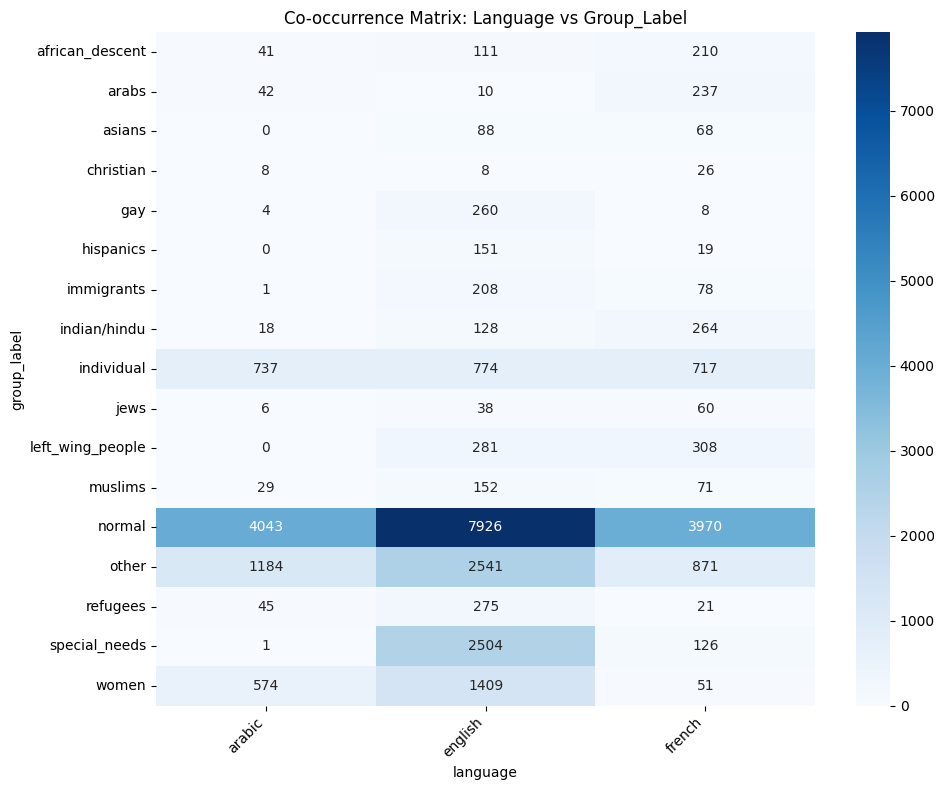


Directness Cooccurrences


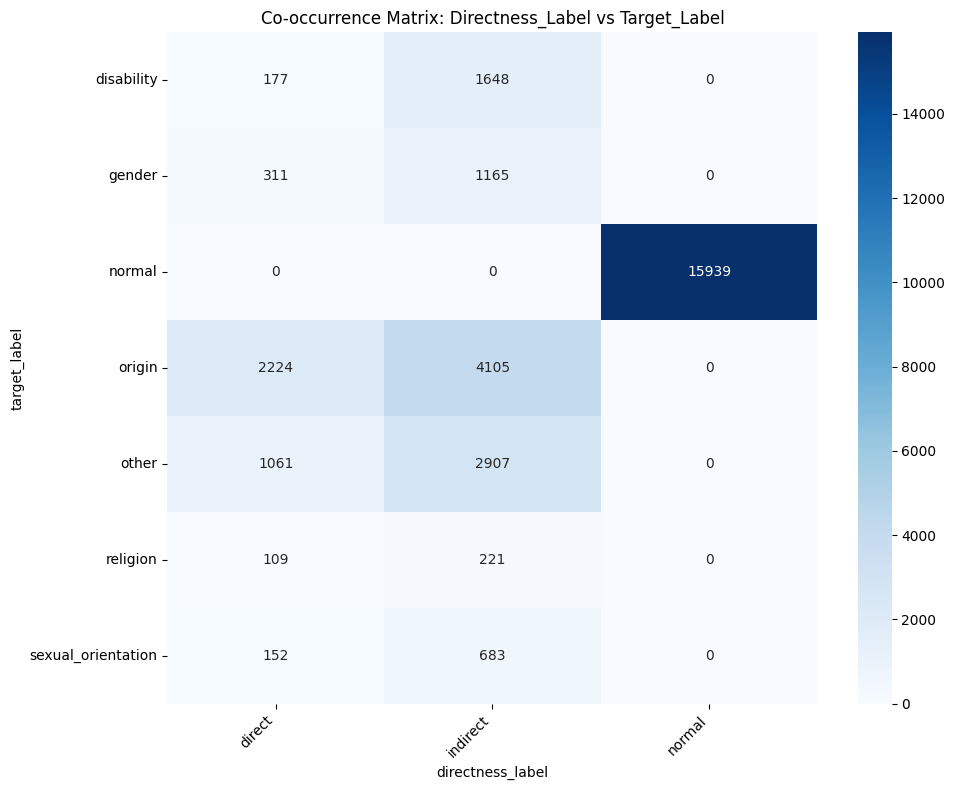

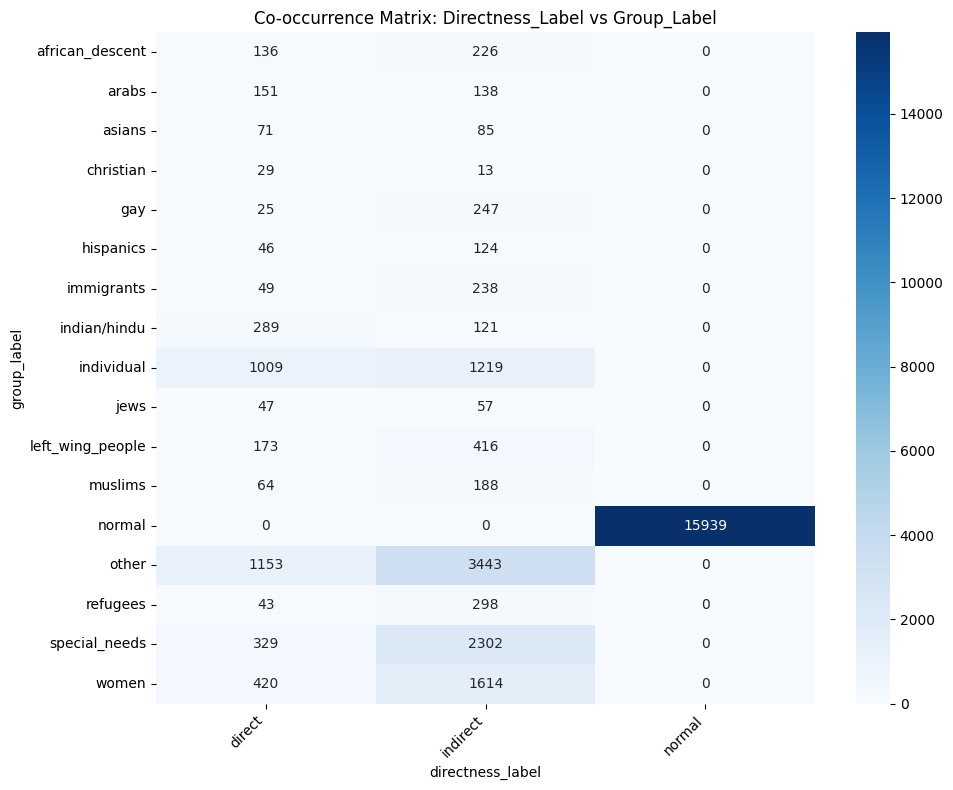

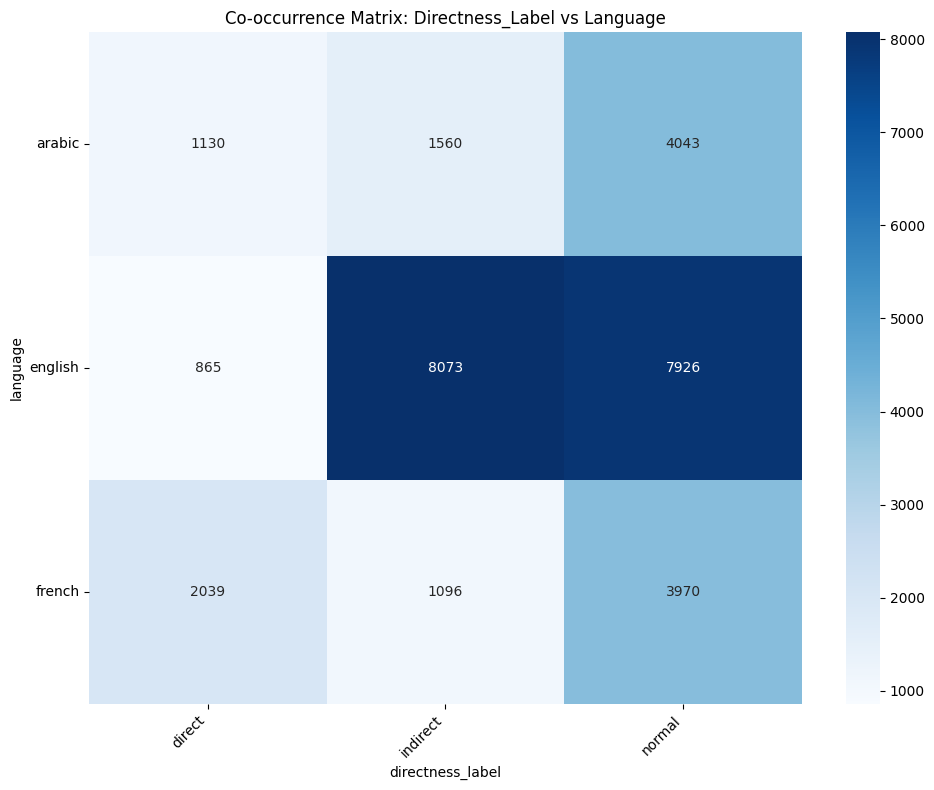


Group vs. Target


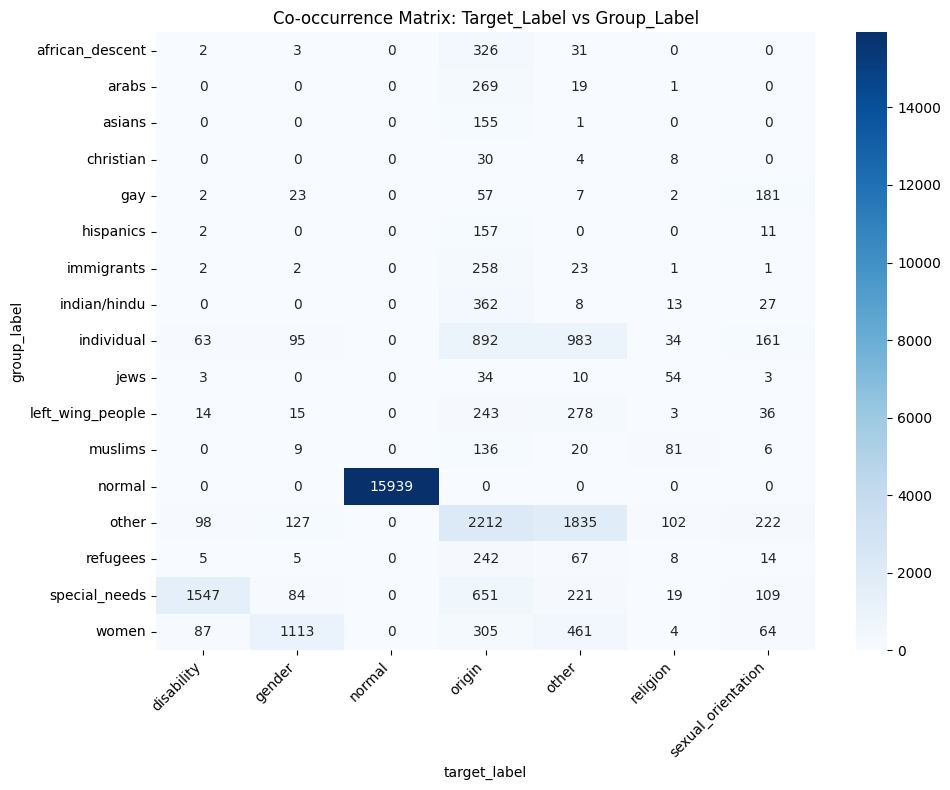

In [25]:
def decode_labels(values, label_map):
    # values: list or index of ints or strings
    # label_map: dict with string keys
    return [label_map.get(str(v), str(v)) for v in values]

def plot_cooccurrence_matrix(col1, col2, col1_name, col2_name, row_map=None, col_map=None):
    cooccurrence = pd.crosstab(
        train_df[col1_name], train_df[col2_name]
    ).reindex(index=col1, columns=col2, fill_value=0)
    # Decode row and column labels if mapping provided
    row_labels = decode_labels(cooccurrence.index, row_map) if row_map else cooccurrence.index.astype(str)
    col_labels = decode_labels(cooccurrence.columns, col_map) if col_map else cooccurrence.columns.astype(str)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f'Co-occurrence Matrix: {col2_name.title()} vs {col1_name.title()}')
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

directness = sorted(train_df['directness_label'].unique())
target = sorted(train_df['target_label'].unique())
group = sorted(train_df['group_label'].unique())
language = sorted(train_df['language'].unique())

print("\nLanguage Cooccurrences")
plot_cooccurrence_matrix(target, language, 'target_label', 'language',
                         row_map=label_maps['target'], col_map=None)
plot_cooccurrence_matrix(group, language, 'group_label', 'language',
                         row_map=label_maps['group'], col_map=None)
print("\nDirectness Cooccurrences")
plot_cooccurrence_matrix(target, directness, 'target_label', 'directness_label',
                         row_map=label_maps['target'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(group, directness, 'group_label', 'directness_label',
                         row_map=label_maps['group'], col_map=label_maps['directness'])
plot_cooccurrence_matrix(language, directness, 'language', 'directness_label',
                         row_map=None, col_map=label_maps['directness'])
print("\nGroup vs. Target")
plot_cooccurrence_matrix(group, target, 'group_label', 'target_label',
                         row_map=label_maps['group'], col_map=label_maps['target'])

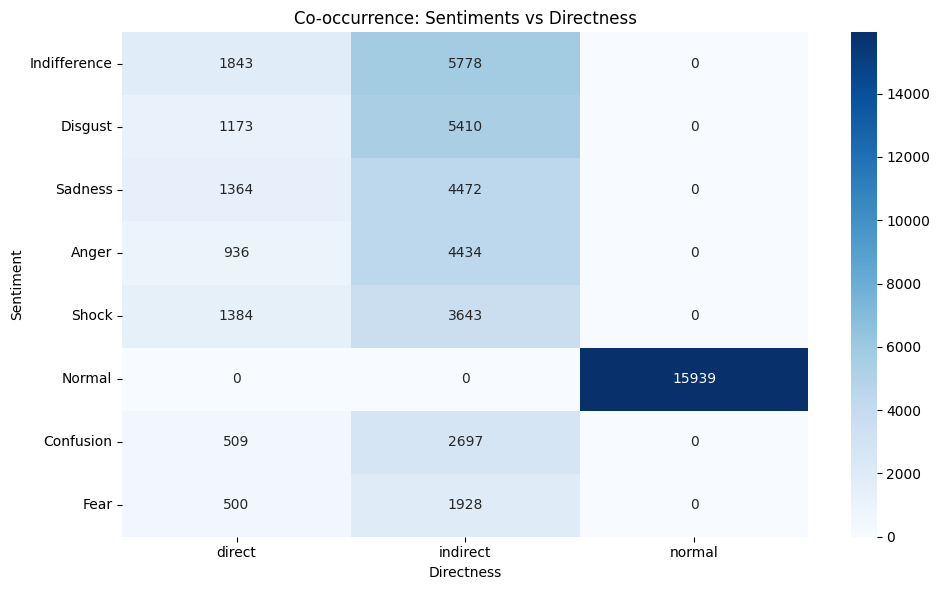

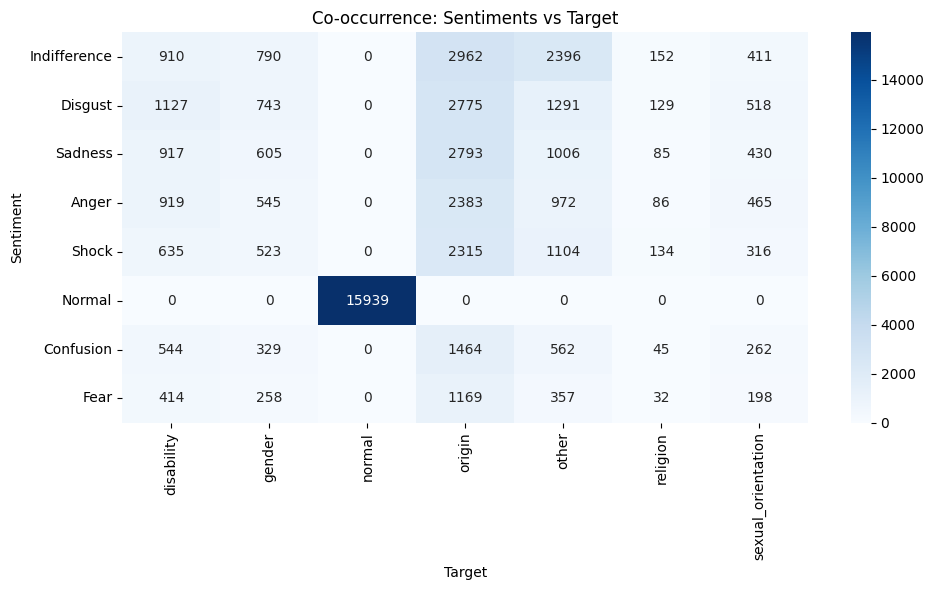

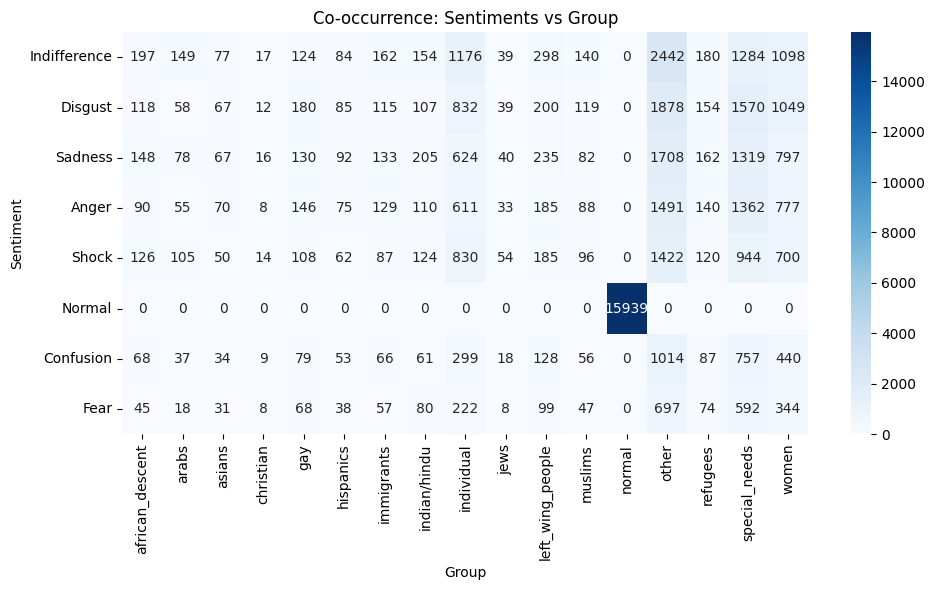

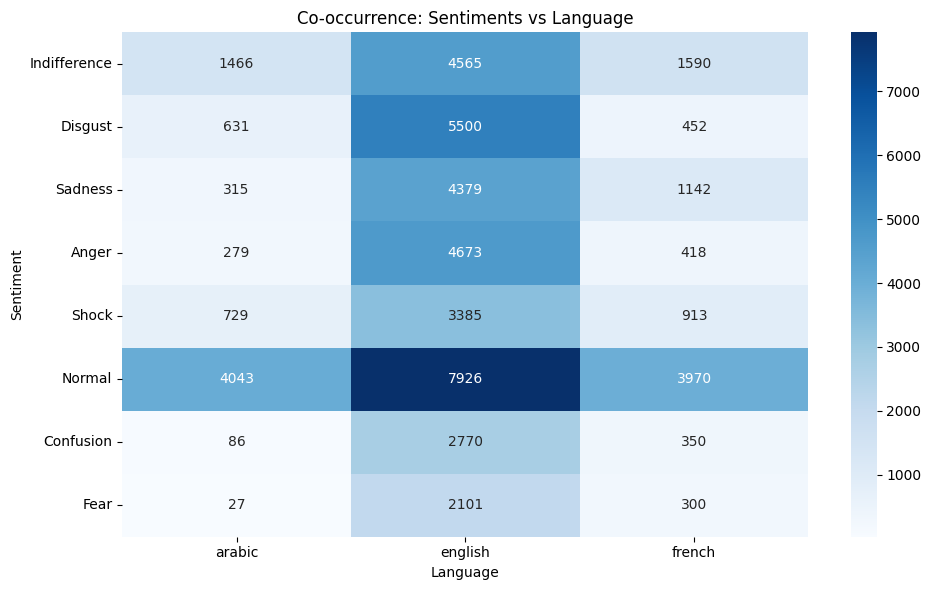

In [26]:
cooccurrence_targets = ['directness_label', 'target_label', 'group_label', 'language']

# Optionally, create a sentiment label map for pretty y-axis labels
sentiment_label_map = {col.replace('sentiment_', ''): col.replace('sentiment_', '').capitalize() for col in sentiment_cols}

for target_col in cooccurrence_targets:
    valid_sentiments = [col for col in sentiment_cols if col in train_df.columns]
    if not valid_sentiments:
        continue

    cooccurrence = pd.DataFrame(
        {sentiment.replace('sentiment_', ''): train_df.groupby(target_col)[sentiment].sum()
         for sentiment in valid_sentiments}
    ).T

    # Use label maps for x-axis (target_col)
    if target_col.replace('_label', '') in label_maps:
        label_map = label_maps[target_col.replace('_label', '')]
        col_labels = [label_map.get(str(idx), str(idx)) for idx in cooccurrence.columns]
    else:
        col_labels = cooccurrence.columns.astype(str)

    # Use sentiment label map for y-axis
    row_labels = [sentiment_label_map.get(idx, idx) for idx in cooccurrence.index]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=row_labels)
    plt.title(f"Co-occurrence: Sentiments vs {target_col.replace('_label','').title()}")
    plt.xlabel(target_col.replace('_label','').title())
    plt.ylabel('Sentiment')
    plt.tight_layout()
    plt.show()

## Exploring Language Differences

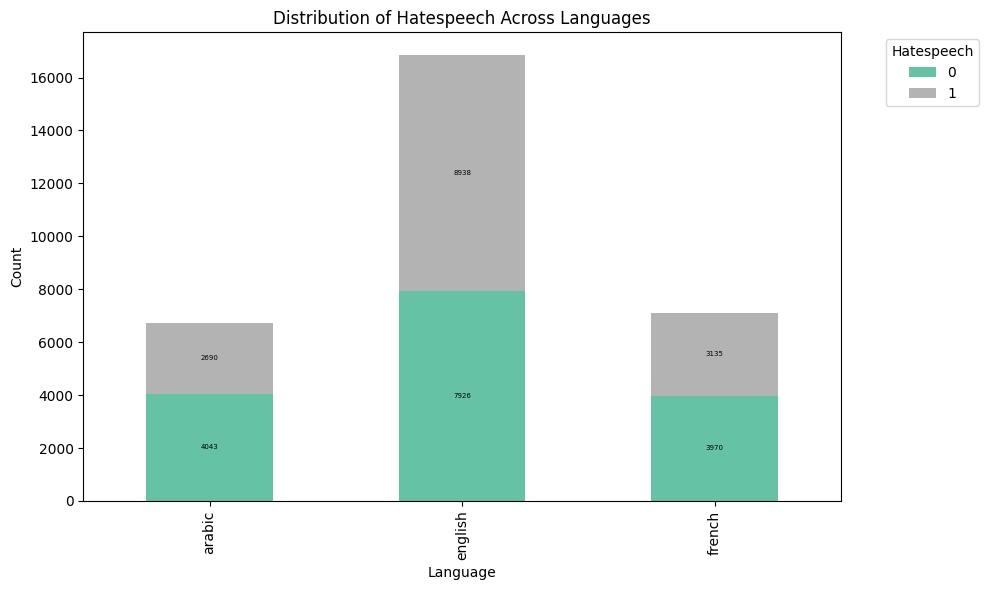

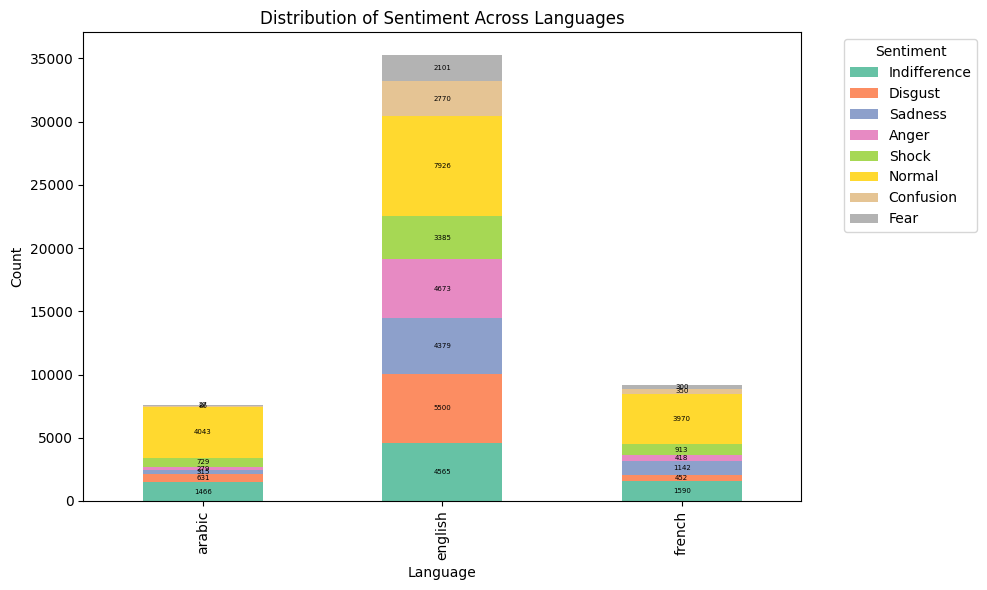

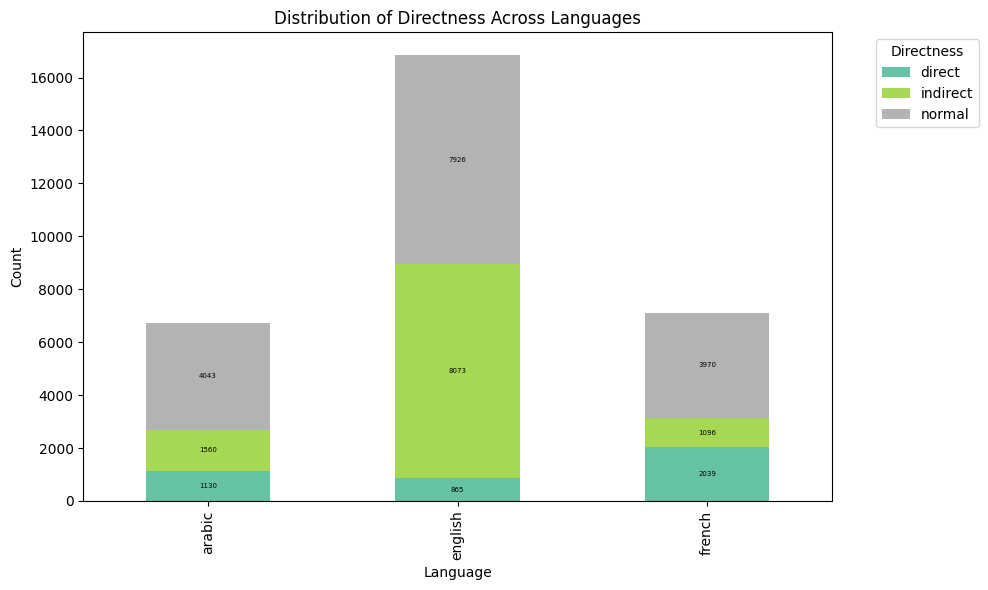

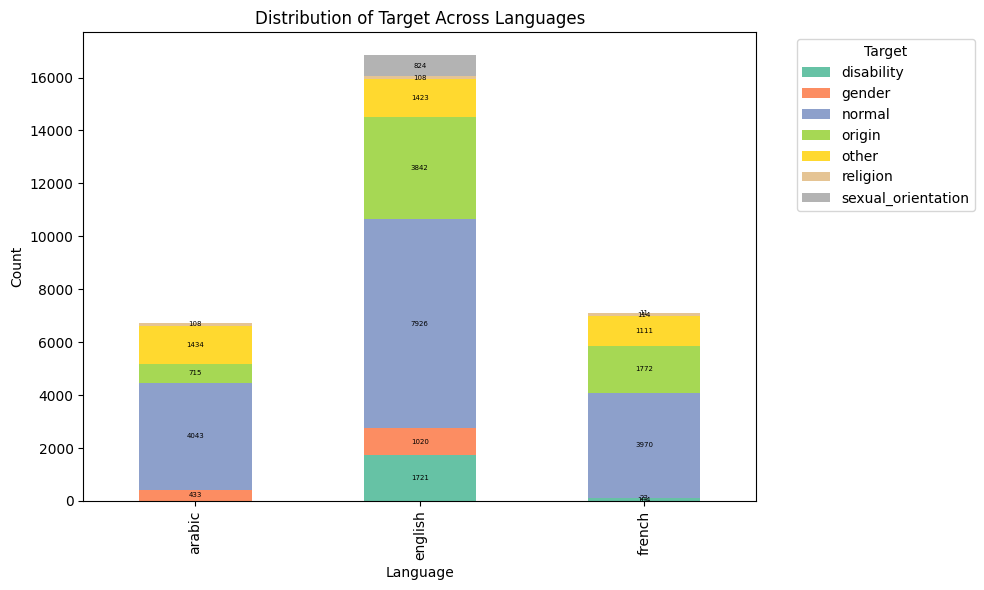

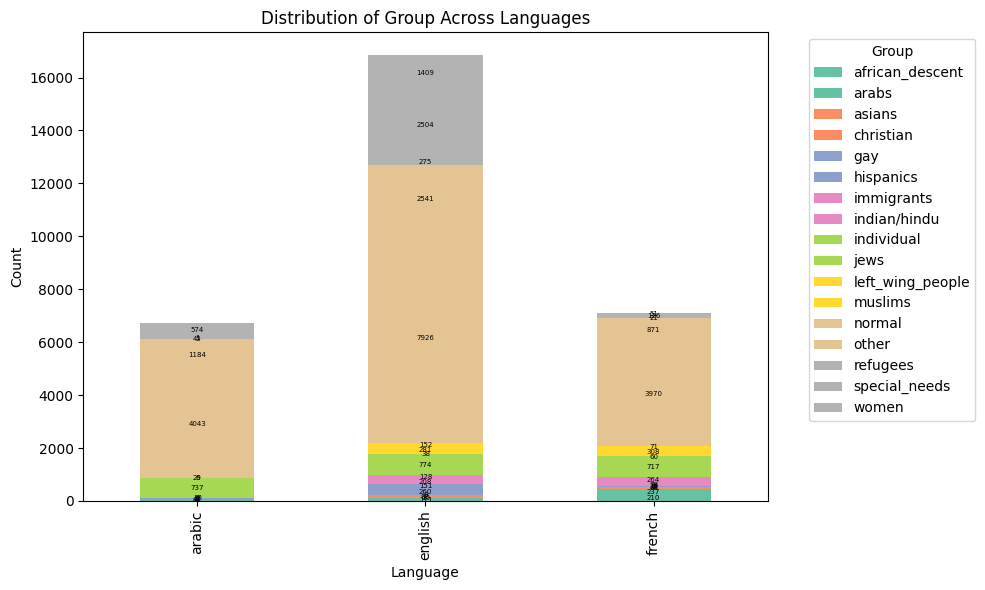

In [27]:
# Language vs. Label Distribution: Stacked Bar Plot (with label maps)
for label in ['hatespeech', 'sentiment', 'directness', 'target', 'group']:
    plt.figure(figsize=(10, 6))
    if label == 'sentiment':
        # Sentiment columns already have readable names
        lang_label_counts = train_df.groupby('language')[sentiment_cols].sum()
        legend_labels = [col.replace('sentiment_', '').capitalize() for col in sentiment_cols]
        lang_label_counts.columns = legend_labels
    else:
        label_col = f"{label}_label" if f"{label}_label" in train_df.columns else label
        lang_label_counts = pd.crosstab(train_df['language'], train_df[label_col])
        # Map legend labels if available
        if label in label_maps:
            legend_labels = [label_maps[label].get(str(idx), str(idx)) for idx in lang_label_counts.columns]
            lang_label_counts.columns = legend_labels
        else:
            legend_labels = lang_label_counts.columns.astype(str)
    ax = lang_label_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,6), ax=plt.gca())
    plt.title(f'Distribution of {label.title()} Across Languages')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.legend(title=label.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Add value counts on top of each bar segment
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                            (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                            ha='center', va='center', fontsize=5, color='black')
    plt.show()

In [28]:
def show_samples_per_class_per_language(column, n=3):
    print(f"\nSample texts for each {column} per language:")
    for lang in train_df['language'].dropna().unique():
        print(f"\n=== Language: {lang} ===")
        if column == 'sentiment':
            for sentiment_col in sentiment_cols:
                sentiment_key = sentiment_col.replace('sentiment_', '')
                sentiment_name = sentiment_key.capitalize()
                print(f"\n--- Sentiment: {sentiment_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[sentiment_col] == 1)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")
        else:
            # Use label map if available
            label_key = column.replace('_label', '')
            label_map = label_maps.get(label_key, {})
            classes = train_df[column].dropna().unique()
            for cls in classes:
                class_name = label_map.get(str(cls), str(cls))
                print(f"\n--- {column.title()}: {class_name} ---")
                samples = train_df[(train_df['language'] == lang) & (train_df[column] == cls)]['text_cleaned'].dropna().head(n)
                if samples.empty:
                    print("No samples available.")
                else:
                    for i, text in enumerate(samples, 1):
                        print(f"{i}. {text}")

In [29]:
show_samples_per_class_per_language('directness_label', n=3)  


Sample texts for each directness_label per language:

=== Language: arabic ===

--- Directness_Label: normal ---
1. يلعن شرفك يا حكم!!!
2. في بني آدم عنده عقل بنزل مادة مقدمة في علم المكتبات!!!
3. اي هيك عم بعمل بكره بصير احسن ...thank you

--- Directness_Label: indirect ---
1. لان دعواتكم خبيثه لذلك الله لم يستجب لها وانقلبت الدعوات عليك وعلى خنازير الجزيره واص…
2. الخنزيره مصدومه من فوز الجمهوريين ههههههه طارت فلوسك ي خنزير
3. -ما بغيتيش خلي دينمها تبقا بايرة

--- Directness_Label: direct ---
1. روح اشرب بول البعير
2. أبناء المسيار و جهاد…
3. نفسي اعرف كيف فكروا ووصلوا لهالنتيجة رفض التحرش = دعوة للرذيلة !!!

=== Language: english ===

--- Directness_Label: normal ---
1. RT @J23app: Feb 2015 Jordan 4 Retro Remastered "Oreo" 314254-003 http://t.co/NBOaxG1S19
2. I just put down a pan of brownies
3. Shaykh Abdul Hakim Murad brilliantly and succinctly explains the definition of Sunni Orthodoxy/ Ahlul Sunnah Wal Jamah'.

--- Directness_Label: indirect ---
1. cunt smashed phone hand last 

In [30]:
show_samples_per_class_per_language('target_label', n=3)  


Sample texts for each target_label per language:

=== Language: arabic ===

--- Target_Label: normal ---
1. يلعن شرفك يا حكم!!!
2. في بني آدم عنده عقل بنزل مادة مقدمة في علم المكتبات!!!
3. اي هيك عم بعمل بكره بصير احسن ...thank you

--- Target_Label: gender ---
1. -ما بغيتيش خلي دينمها تبقا بايرة
2. قصص التحرش والاغتصاب اللي قاعده اقراها تخوف وتبين انو فعلاً مافي امان وان في حيوانات حتى الحيوانات مايسوون افعالهم…
3. نفسي اعرف كيف فكروا ووصلوا لهالنتيجة رفض التحرش = دعوة للرذيلة !!!

--- Target_Label: other ---
1. الخنزيره مصدومه من فوز الجمهوريين ههههههه طارت فلوسك ي خنزير
2. سؤال هل شربت بول البعير
3. مشوار المستشفي دا اكتر مشوار وسخ ف حياة الانسان

--- Target_Label: origin ---
1. روح اشرب بول البعير
2. لان دعواتكم خبيثه لذلك الله لم يستجب لها وانقلبت الدعوات عليك وعلى خنازير الجزيره واص…
3. أبناء الإبل يتفاخرون بأن جمالهم المشاركة في السباق الذي يعتبر الإنجاز الأعظم لمملكة بول البعير، يتفاخرون بأنها أكثر…

--- Target_Label: disability ---
No samples available.

--- Target_Label: sex

In [31]:
show_samples_per_class_per_language('group_label', n=3)  


Sample texts for each group_label per language:

=== Language: arabic ===

--- Group_Label: normal ---
1. يلعن شرفك يا حكم!!!
2. في بني آدم عنده عقل بنزل مادة مقدمة في علم المكتبات!!!
3. اي هيك عم بعمل بكره بصير احسن ...thank you

--- Group_Label: women ---
1. -ما بغيتيش خلي دينمها تبقا بايرة
2. قصص التحرش والاغتصاب اللي قاعده اقراها تخوف وتبين انو فعلاً مافي امان وان في حيوانات حتى الحيوانات مايسوون افعالهم…
3. نفسي اعرف كيف فكروا ووصلوا لهالنتيجة رفض التحرش = دعوة للرذيلة !!!

--- Group_Label: other ---
1. لان دعواتكم خبيثه لذلك الله لم يستجب لها وانقلبت الدعوات عليك وعلى خنازير الجزيره واص…
2. الخنزيره مصدومه من فوز الجمهوريين ههههههه طارت فلوسك ي خنزير
3. أبناء المسيار و جهاد…

--- Group_Label: indian/hindu ---
1. كف كموم زنود ثوبك يدك ادخله حان وقت اصلا دود علي فران هندوس
2. والله انكم هندوس مافي فرق بينكم ياشيعه #يزيد_بن_معاويه_رضي_الله_عنه
3. نعم يا محمد السودان فيه هندوس ليهم 50 او 70 سنه متواجدين في الخرطوم وا…

--- Group_Label: special_needs ---
1. من كتر ما عقلي معاق ماسكه 

In [32]:
show_samples_per_class_per_language('sentiment', n=3)  


Sample texts for each sentiment per language:

=== Language: arabic ===

--- Sentiment: Indifference ---
1. أبناء المسيار و جهاد…
2. -ما بغيتيش خلي دينمها تبقا بايرة
3. نفسي اعرف كيف فكروا ووصلوا لهالنتيجة رفض التحرش = دعوة للرذيلة !!!

--- Sentiment: Disgust ---
1. نفسي اعرف كيف فكروا ووصلوا لهالنتيجة رفض التحرش = دعوة للرذيلة !!!
2. هو البدوي شارب بول البعير ليه بيوافق نسوانه تشوف اجسام و فخاد و حمامة رجال مفتولي العضلات و مش موافق الستات الرجال…
3. دكتور بيطري تخصص خنازير

--- Sentiment: Sadness ---
1. قصص التحرش والاغتصاب اللي قاعده اقراها تخوف وتبين انو فعلاً مافي امان وان في حيوانات حتى الحيوانات مايسوون افعالهم…
2. المذكوره أعلاه لها مقاطع في اليوتوب عندما كانت بقره حلوب متبرجه ومن كلامها في…
3. ياك ما ولاو دايرين التحرش مقياس للجمال

--- Sentiment: Anger ---
1. هو البدوي شارب بول البعير ليه بيوافق نسوانه تشوف اجسام و فخاد و حمامة رجال مفتولي العضلات و مش موافق الستات الرجال…
2. دور لك احد ثاني غير الحريم تطلع مرجلتك عليه
3. لا نشرب بول البعير ومن علمك الدين مغفل واحمق مثلك الد